<a href="https://colab.research.google.com/github/AlexanderPidodnya/MaisRecognition/blob/main/Mais_Training_and_Detection_ipynb_290622.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup Paths

In [11]:
#only for colab
!pip uninstall tensorflow -q
#!pip install tensorflow==2.7.0
!pip install tensorflow==2.8 -q
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
#restart kernel

Proceed (y/n)? y
     / 668.3 MB 146 kB/s
     |████████████████████████████████| 462 kB 33.4 MB/s 
     |████████████████████████████████| 5.8 MB 62.1 MB/s 
     |████████████████████████████████| 1.4 MB 49.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.9.2 requires tensorflow~=2.9.0, but you have tensorflow 2.8.0+zzzcolab20220506162203 which is incompatible.
tensorflow-text 2.9.0 requires tensorflow<2.10,>=2.9.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.8.0+zzzcolab20220506162203 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
T

In [3]:
import os
import tensorflow as tf
import numpy as np
print(tf.__version__)
print(tf.config.list_physical_devices())

2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
CUSTOM_MODEL_NAME = 'my_mobilenet' 
#PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
#PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
#PRETRAINED_MODEL_NAME = 'ssd_resnet152_v1_fpn_1024x1024_coco17_tpu-8'
#PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet152_v1_fpn_1024x1024_coco17_tpu-8.tar.gz'
#PRETRAINED_MODEL_NAME = 'efficientdet_d6_coco17_tpu-32'
#PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d6_coco17_tpu-32.tar.gz'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [5]:
np.__version__, tf.__version__

('1.21.6', '2.8.0')

In [ ]:
!pip install numpy==1.19.5

In [6]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [7]:
files

{'LABELMAP': 'Tensorflow/workspace/annotations/label_map.pbtxt',
 'PIPELINE_CONFIG': 'Tensorflow/workspace/models/my_mobilenet/pipeline.config',
 'TF_RECORD_SCRIPT': 'Tensorflow/scripts/generate_tfrecord.py'}

In [7]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [8]:
if os.name=='nt':
    !pip install wget
    import wget

In [8]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 74814, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 74814 (delta 172), reused 237 (delta 125), pack-reused 74512
Receiving objects: 100% (74814/74814), 580.50 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (53066/53066), done.


In [9]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/Tensorflow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.9 MB 58.2 MB/s 
     |██████████████████████████████

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-06-29 17:32:33.615878: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0629 17:32:34.056421 140379095660416 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.99s
I0629 17:32:34.680832 140379095660416 test_util.py:2459] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.99s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 1.06s
I0629 17:32:35.742551 140379095660416 test_u

In [ ]:
#!unzip -q '/content/drive/MyDrive/diploma/base/stampsignatures.zip' -d /content/Tensorflow/workspace/images

In [ ]:
!unzip -q '/content/drive/MyDrive/collectedimages.zip' -d /content/Tensorflow/workspace/images

In [ ]:
!rm -rf /content/Tensorflow/workspace/images
!mkdir  /content/Tensorflow/workspace/images

In [ ]:
#!pip install tensorflow-gpu --upgrade

     |████████████████████████████████| 497.5 MB 25 kB/s 


In [ ]:
#!pip uninstall protobuf matplotlib -y
#!pip install protobuf matplotlib==3.2

Found existing installation: protobuf 3.15.7
Uninstalling protobuf-3.15.7:
  Successfully uninstalled protobuf-3.15.7
Found existing installation: matplotlib 3.4.1
Uninstalling matplotlib-3.4.1:
  Successfully uninstalled matplotlib-3.4.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.28.0 requires crcmod<2.0,>=1.7, which is not installed.
apache-beam 2.28.0 requires dill<0.3.2,>=0.3.1.1, which is not installed.
apache-beam 2.28.0 requires fastavro<2,>=0.21.4, which is not installed.
apache-beam 2.28.0 requires future<1.0.0,>=0.18.2, which is not installed.
apache-beam 2.28.0 requires grpcio<2,>=1.29.0, which is not installed.
apache-beam 2.28.0 requires hdfs<3.0.0,>=2.1.0, which is not installed.
apache-beam 2.28.0 requires httplib2<0.18.0,>=0.8, which is not installed.
apache-beam 2.28.0 requires mock<3.0.0,>=1.0.1, which is not installed.
tensorflow 2.5.0rc0 requires astunparse~=1.6.3, which is not installed.
tensorflow 2.5.0rc0 requires flatbuffers~=1.12.0, which is not installed.
tensorflow 2.5.0rc0 requires gast==0.4.0, which is not installed.
tensorflow 2.5.0rc0 requires go


  Using cached matplotlib-3.2.0-cp37-cp37m-win_amd64.whl (9.2 MB)


In [12]:
import object_detection

In [ ]:
!pip list  #curr

In [ ]:
!pip list

In [13]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2022-06-29 17:33:25--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.10.128, 2404:6800:4003:83b::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.10.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  46.8MB/s    in 0.4s    

2022-06-29 17:33:26 (46.8 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_640x640_coco17_tp

# 2. Create Label Map

In [6]:
labels_ = [{'name':'thumbsup', 'id':1},
          {'name':'thumbsdown', 'id':2}, 
          {'name':'thankyou', 'id':3},
          {'name':'fist', 'id':4},
          {'name':'united', 'id':5},
          {'name':'victory', 'id':6}]
          
labels = [{'name' : 'mais', 'id':1},
          {'name' : 'dill', 'id':2},
          {'name' : 'buckwheat', 'id':3},
          {'name' : 'other', 'id':4}]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item {\n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [15]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [16]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

Cloning into 'Tensorflow/scripts'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [17]:
resources = '/content/resources'
if not os.path.exists(resources):
  !mkdir {resources}
!git clone https://github.com/AlexanderPidodnya/MaisRecognition {resources}

Cloning into '/content/resources'...
remote: Enumerating objects: 2001, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 2001 (delta 26), reused 35 (delta 25), pack-reused 1962
Receiving objects: 100% (2001/2001), 121.59 MiB | 17.15 MiB/s, done.
Resolving deltas: 100% (1532/1532), done.


In [18]:
#coping from resources
import glob, shutil
onColab = os.name =='posix' 
if not onColab:

  res_img = r'C:\Users\AdminAsus\PycharmProjects\MaisRecognition\resources'
  train_path = os.path.join(paths['IMAGE_PATH'], 'train')
  test_path = os.path.join(paths['IMAGE_PATH'], 'test')
  if not os.path.exists(train_path):
      !mkdir {train_path}
  if not os.path.exists(test_path):
      !mkdir {test_path}
if onColab:
  res_img = r'/content/resources/SlicedImages_3'
  train_path = os.path.join(paths['IMAGE_PATH'], 'train')
  test_path = os.path.join(paths['IMAGE_PATH'], 'test')
  if not os.path.exists(train_path):
      !mkdir {train_path}
  if not os.path.exists(test_path):
      !mkdir {test_path}

imgs = []
rr = '.jpg'
for img in os.listdir(res_img):
  if rr in img.lower():
    imgs.append(img[:-4])
tr_k = len(imgs) * 0.95
for i, img in enumerate(imgs):
  fList = glob.glob(os.path.join(res_img, img+'*.*'))
  
  for f in fList:
    #print(f)
    if i<tr_k:
      if onColab:
        !cp {f} {train_path} 
      else:
        !copy {f} {train_path} 
    else:
      if onColab:
        !cp {f} {test_path}        
      else:
        !copy {f} {test_path}        
# may use a directive like !copy

In [13]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 4. Copy Model Config to Training Folder

In [14]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [18]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [23]:
tf.__version__

'2.8.0'

In [15]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [16]:
config

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.9969999790191

In [19]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [20]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [21]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [22]:
pipeline_config

model {
  ssd {
    num_classes: 4
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
 

# 6. Train the model

In [30]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [31]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=25000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [32]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_mobilenet --pipeline_config_path=Tensorflow/workspace/models/my_mobilenet/pipeline.config --num_train_steps=25000


In [26]:
pip install opencv-python-headless==4.5.2.52

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 1.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [34]:
!{command}

2022-06-29 04:42:32.962989: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0629 04:42:32.982072 140200934459264 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 25000
I0629 04:42:32.988182 140200934459264 config_util.py:552] Maybe overwriting train_steps: 25000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0629 04:42:32.988411 140200934459264 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0629 04:42:33.222772 140200934459264 deprecation.py:356] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experiment

# 7. Evaluate the Model

In [36]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [37]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_mobilenet --pipeline_config_path=Tensorflow/workspace/models/my_mobilenet/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_mobilenet


In [38]:
!{command}

W0627 19:05:06.283538 139942201255808 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0627 19:05:06.283741 139942201255808 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0627 19:05:06.283829 139942201255808 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0627 19:05:06.283916 139942201255808 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0627 19:05:06.284029 139942201255808 model_lib_v2.py:1110] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2022-06-27 19:05:07.093841: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config 

# 8. Load Train Model From Checkpoint

restart  the kernel to import model_bulider

In [8]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [9]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-25')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [10]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

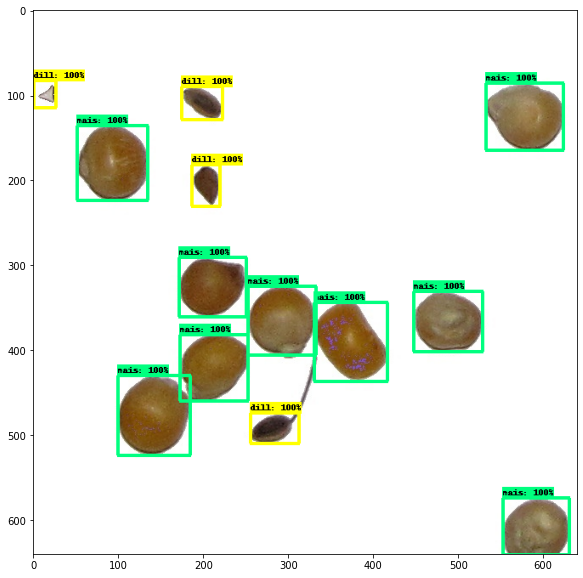

In [16]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'IMG_4316_wb12.jpg')
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            #max_boxes_to_draw=5,
            #min_score_thresh=.8,
           # agnostic_mode=False
           
            )
plt.figure(figsize = (15,10))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()